In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import import_ipynb
from GradaGradSimplified import GradaGradSimplified
import torch.nn as nn
from DLRM_model import DLRM
from sklearn.metrics import accuracy_score

In [2]:
df=pd.read_csv('dac.csv')
df=df.fillna(0)
df

,Unnamed: 0,label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0,0.001799,0.000162,0.000076,0.000000,7.937383e-04,0.000246,0.001703,0.000428,...,9,2422,150,3,1163,0,2,9570,41,5604
1,1,0,0.003597,0.000108,0.000671,0.002398,5.858271e-05,0.000491,0.000227,0.000428,...,0,1727,150,1,14512,0,2,3233,41,4215
2,2,0,0.003597,0.000108,0.000015,0.033573,4.405190e-04,0.005463,0.000454,0.000428,...,6,510,0,0,34644,6,2,2818,0,0
3,3,0,0.000000,0.048316,0.000000,0.000000,2.522503e-03,0.000000,0.000000,0.000000,...,1,1170,0,0,15997,0,2,6971,0,0
4,4,0,0.005396,0.000054,0.000000,0.000000,1.148681e-06,0.000000,0.000341,0.000000,...,1,390,0,0,5101,0,1,8663,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0,0.001799,0.003347,0.000565,0.000000,5.743403e-07,0.000000,0.000454,0.000000,...,9,560,150,3,5553,0,1,3818,12,4183
99996,99996,1,0.000000,0.000108,0.000183,0.000000,9.943037e-02,0.000000,0.000000,0.000641,...,9,1727,150,3,14512,0,1,3233,43,4215
99997,99997,0,0.017986,0.000216,0.000015,0.062350,2.768320e-04,0.003683,0.001135,0.002352,...,0,1648,150,2,12138,0,1,2271,2,8780
99998,99998,0,0.000000,0.021162,0.000656,0.009592,1.983570e-01,0.000000,0.000000,0.000855,...,9,302,0,0,32886,0,1,6918,0,0


In [3]:
dense_features = [f'I{i}' for i in range(1, 14)]
sparse_features = [f'C{i}' for i in range(1, 27)]
target = 'label'

In [4]:
scaler = MinMaxScaler()
df[dense_features] = scaler.fit_transform(df[dense_features])

for col in sparse_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X_dense = df[dense_features].values.astype(np.float32)
X_sparse = df[sparse_features].values.astype(np.int64)
y = df[target].values.astype(np.float32)

In [5]:
from sklearn.model_selection import train_test_split
X_dense_train, X_dense_test, X_sparse_train, X_sparse_test, y_train, y_test = train_test_split(
    X_dense, X_sparse, y, test_size=0.2, random_state=42
)

batch_size = 128
train_dataset = TensorDataset(torch.tensor(X_sparse_train), torch.tensor(X_dense_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_sparse_test), torch.tensor(X_dense_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def compute_accuracy(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_sparse, x_dense, y in test_loader:
            x_sparse = x_sparse.to(device)
            x_dense = x_dense.to(device)
            y = y.to(device)
            outputs = model(x_sparse, x_dense)
            preds = (outputs > 0.5).float()
            all_preds.append(preds)
            all_labels.append(y)

    all_preds = torch.cat(all_preds).cpu()
    all_labels = torch.cat(all_labels).cpu()
    accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
    return accuracy

def train_model_with_gradagrad(model, train_loader, test_loader, epochs, rho_values, gamma_values):
    history = {}

    for rho in rho_values:
        for gamma in gamma_values:
            optimizer = GradaGradSimplified(model.parameters(), gamma=gamma, rho=rho)
            accuracy_epoch = []
            lr_steps = []
            lr_steps_zoom = []
            for epoch in tqdm(range(epochs)):
                model.train()
                epoch_loss = 0
                for i, (x_sparse, x_dense, y) in enumerate(train_loader):
                    x_sparse = x_sparse.to(device)
                    x_dense = x_dense.to(device)
                    y = y.to(device)
                    optimizer.zero_grad()
                    output = model(x_sparse, x_dense)
                    loss = torch.nn.BCEWithLogitsLoss()(output.squeeze(), y)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    A_inv = optimizer.state[optimizer.param_groups[0]['params'][0]]['A_inv']
                    lr_steps.append(1.0 / A_inv)
                    if epoch == 0 and i < 50:
                        lr_steps_zoom.append(1.0 / A_inv)

                accuracy = compute_accuracy(model, test_loader)
                accuracy_epoch.append(accuracy)

            history[(rho, gamma)] = {
                'accuracy': accuracy_epoch,
                'lr_steps': lr_steps,
                'lr_steps_zoom': lr_steps_zoom
            }
    return history


rho_values = [2, 10, 100]
gamma_values = [1.0, 0.01, 0.0001]
epochs = 10

sparse_feature_number = 26
dense_feature_number = 13
num_embeddings = 100000
embed_dim = 16
bottom_mlp_dims = [256, 128]
top_mlp_dims = [64, 32]

model = DLRM(sparse_feature_number, dense_feature_number, num_embeddings, embed_dim, bottom_mlp_dims, top_mlp_dims, self_interaction=True).to(device)

history = train_model_with_gradagrad(model, train_loader, test_loader, epochs, rho_values, gamma_values)

100%|██████████| 10/10 [09:17<00:00, 55.77s/it]


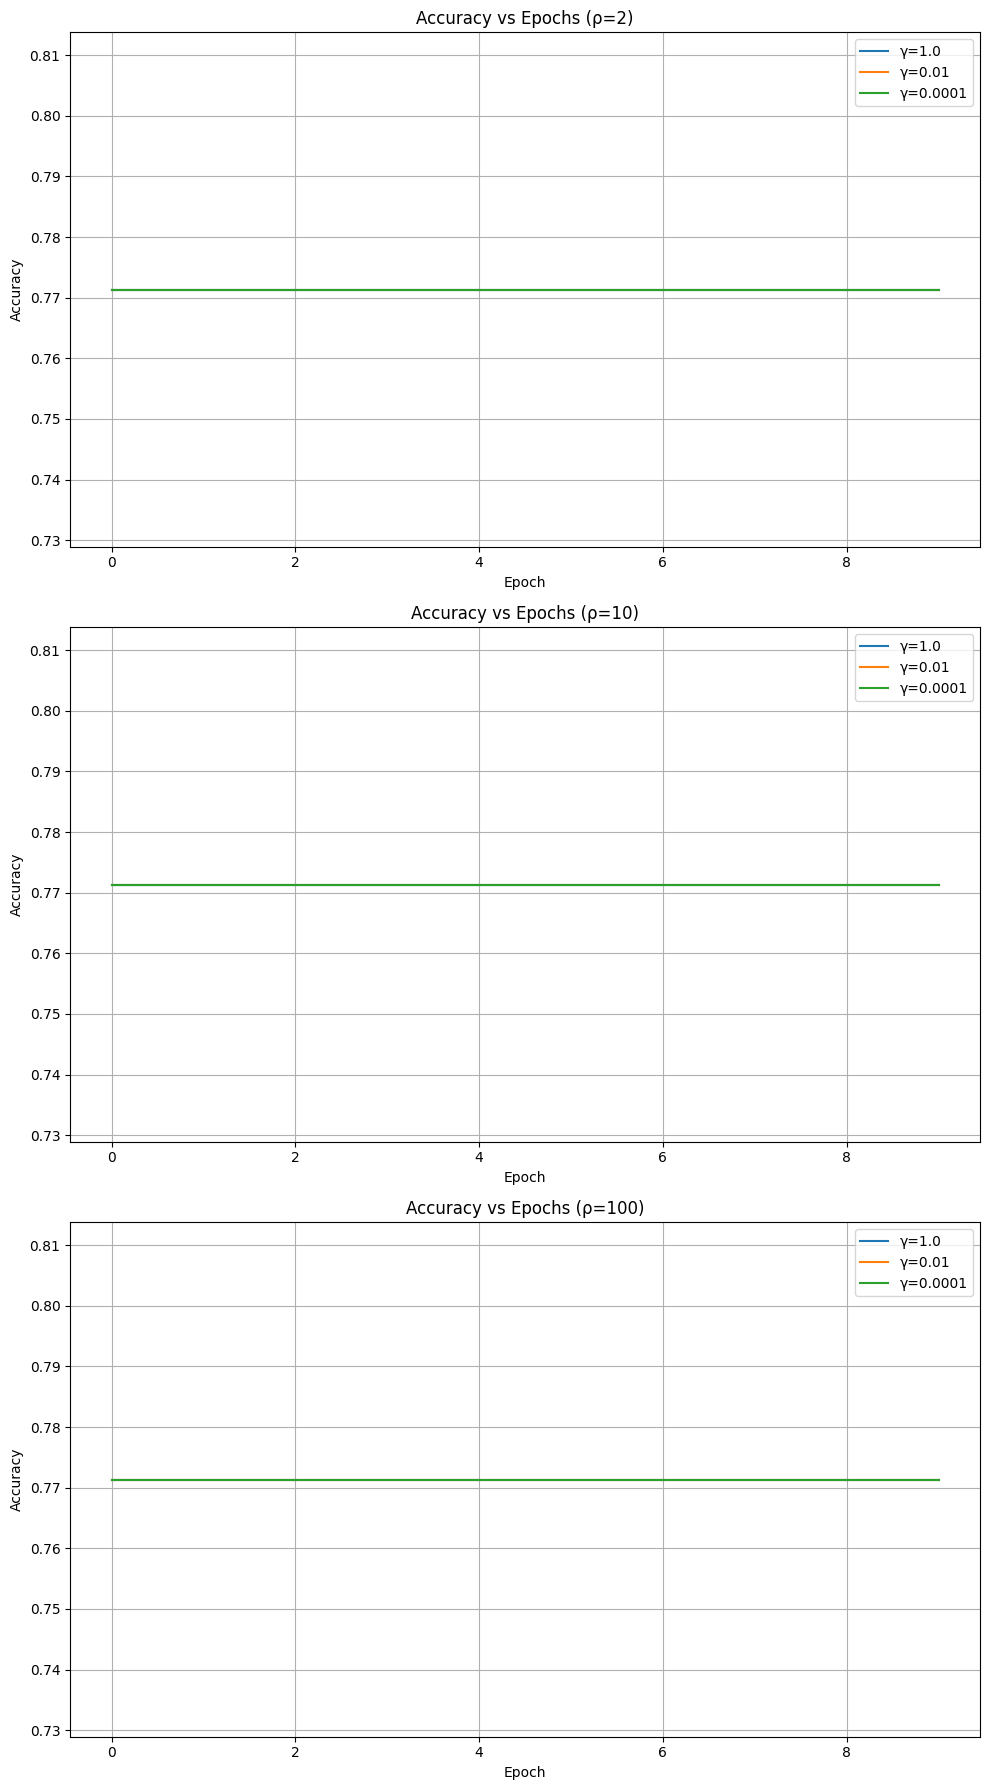

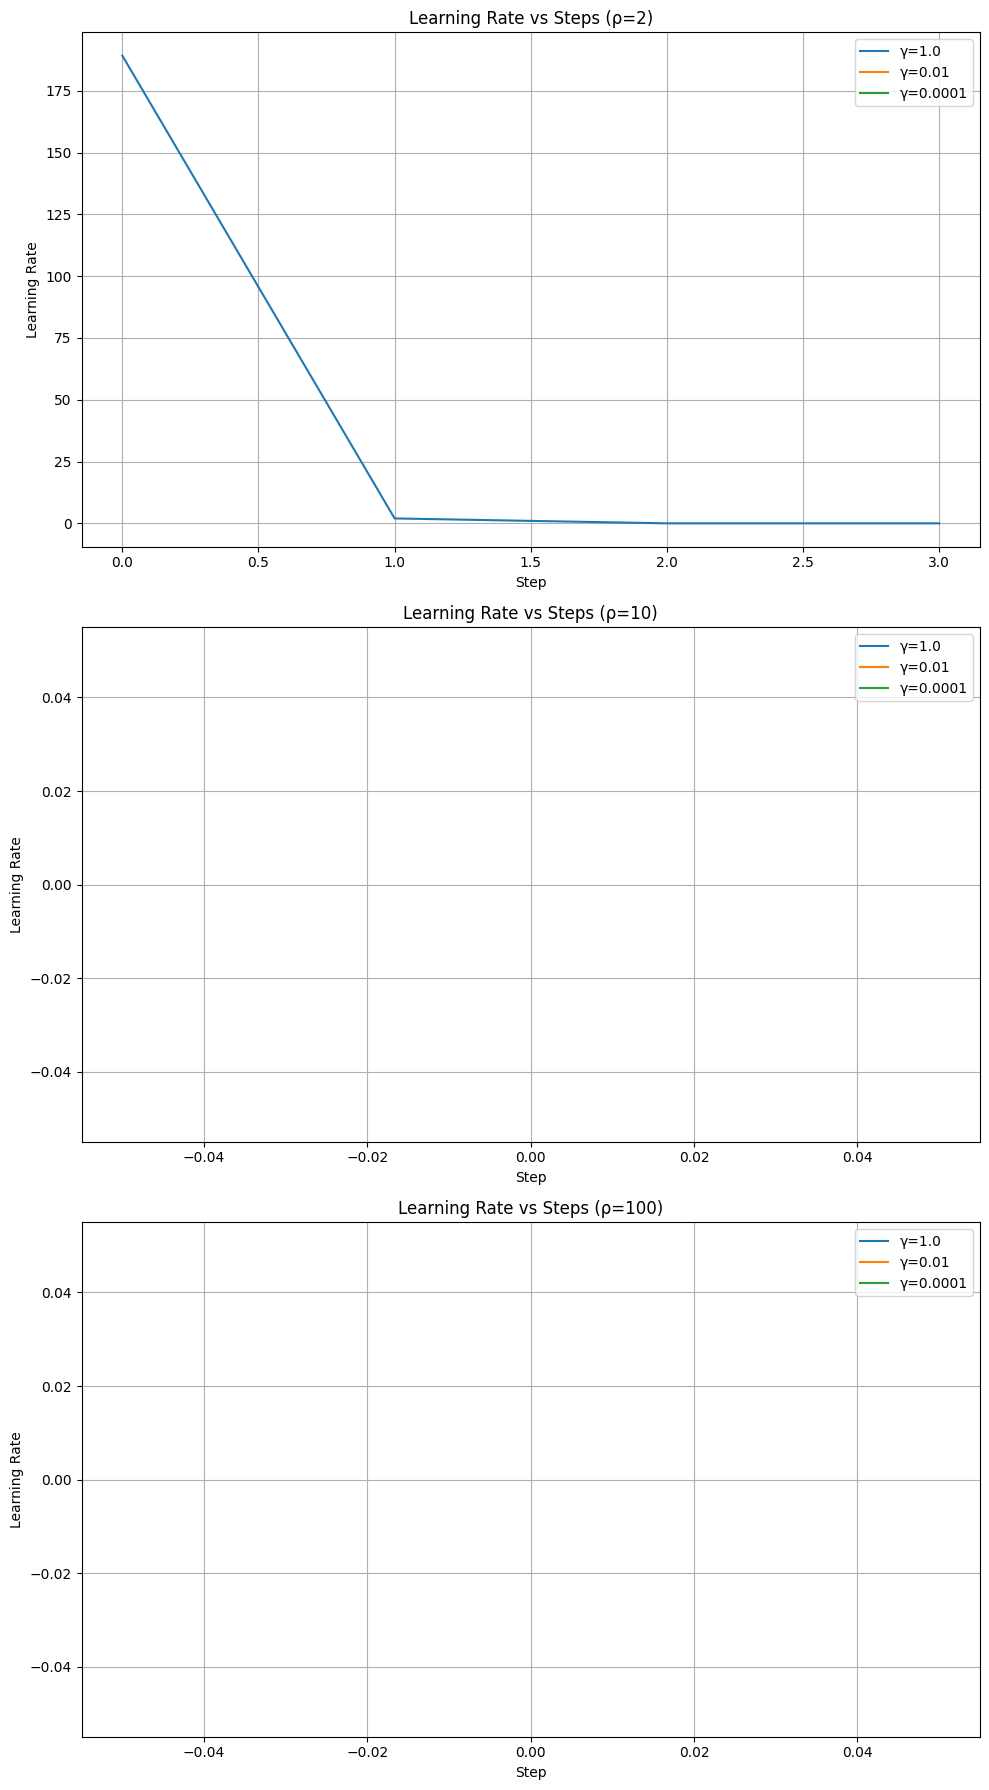

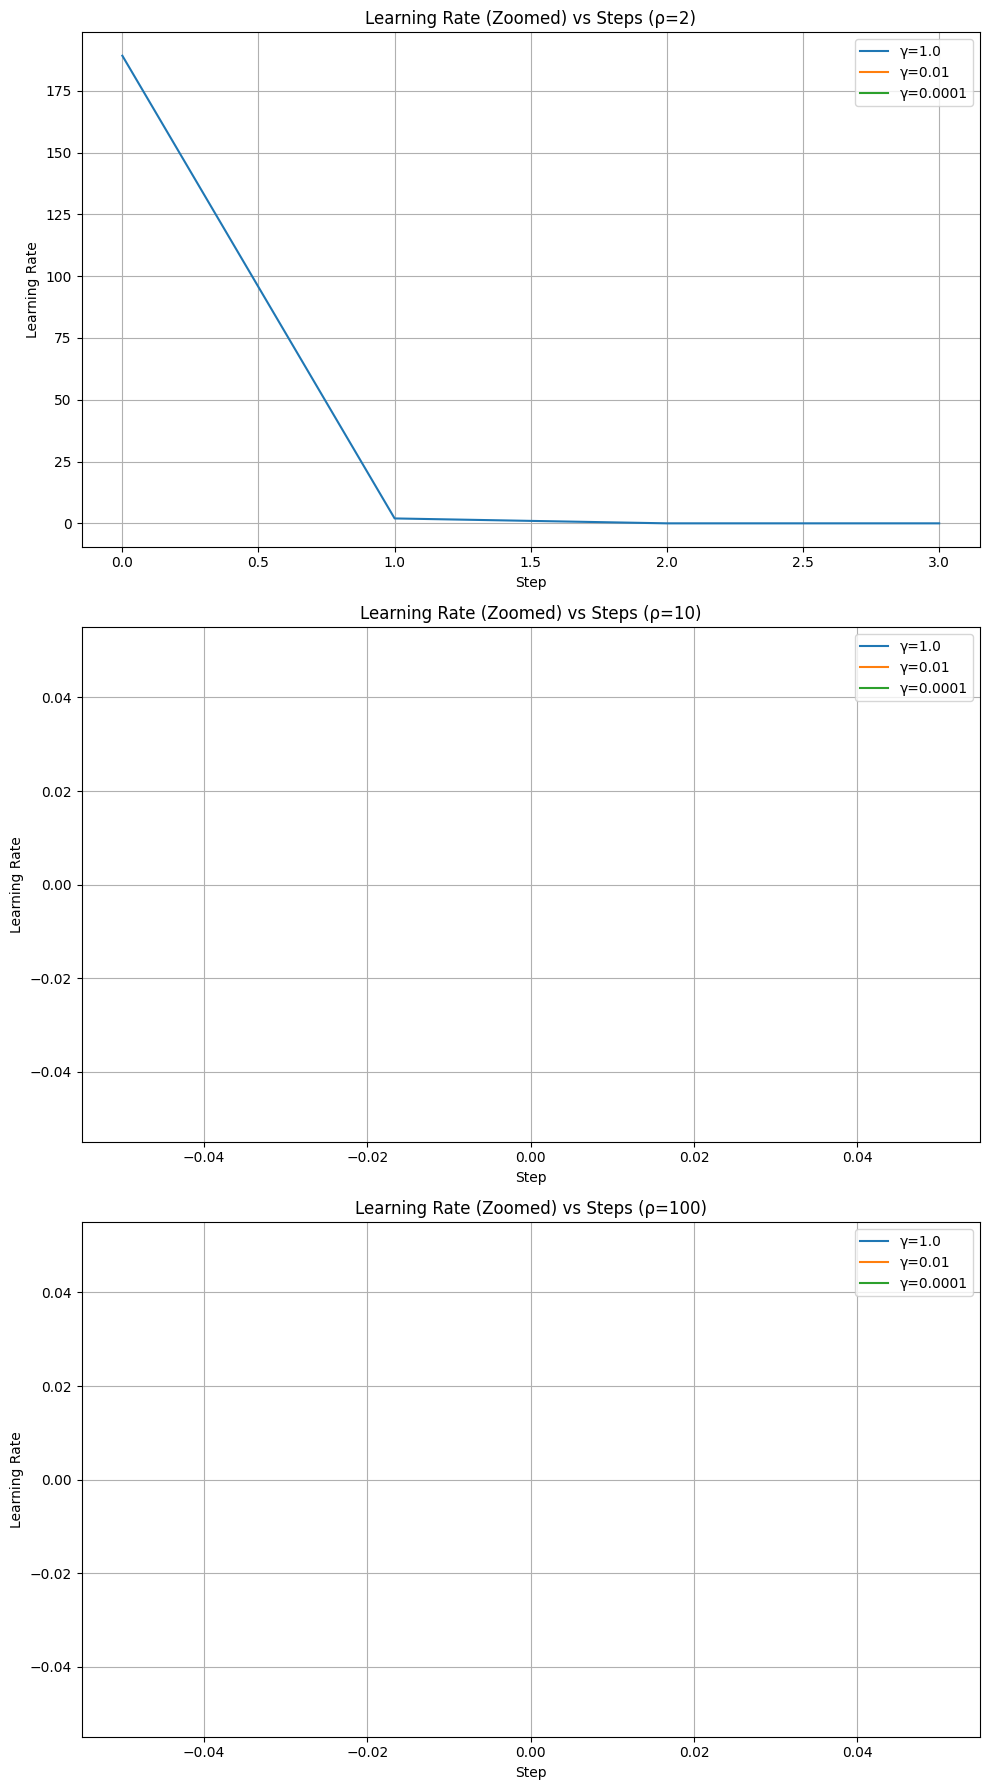

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for idx, rho in enumerate(rho_values):
    ax1 = axes[idx]

    for gamma in gamma_values:
        key = (rho, gamma)
        ax1.plot(range(epochs), history[key]['accuracy'], label=f"γ={gamma}")
    ax1.set_title(f"ρ={rho}")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for idx, rho in enumerate(rho_values):
    ax = axes[idx]
    for gamma in gamma_values:
        key = (rho, gamma)
        ax.plot(history[key]['lr_steps'], label=f"γ={gamma}")
    ax.set_title(f"ρ={rho}")
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for idx, rho in enumerate(rho_values):
    ax = axes[idx]
    for gamma in gamma_values:
        key = (rho, gamma)
        ax.plot(history[key]['lr_steps_zoom'], label=f"γ={gamma}")
    ax.set_title(f"ρ={rho}")
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate (Zoomed) ')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
